# Traffic Flow Data (Jam Factors)

This example looks at OLP traffic flow data (jam factors between 0 and 10) on road segments of one specific partition (map tile). It first makes a histogram of all jam factors for that partition, then renders all available segments inside it on a simple HLS map, and finally renders grouped  jam factors for these segments as overlays to an existing HLS map showing traffic tiles. Unsurprisingly it finds much more detailed traffic data in OLP. 

In [72]:
!pip install sidecar==0.3.0

The system cannot find the path specified.


In [73]:
import itertools

import numpy as np
import pandas as pd
import json
from ipyleaflet import GeoJSON
from ipyleaflet import LayersControl

try:
    from sidecar import Sidecar
    HAVE_SIDECAR = True
except ImportError:
    HAVE_SIDECAR = False    

import nagini

## Access catalogs, layers, partition IDs...

In [74]:
olp = nagini.resource('olp')

cat1 = olp.catalog_by_hrn('hrn:here:data:::olp-traffic-1')
layer1 = cat1.layer_by_id('traffic-flow')
schema1 = layer1.read_schema()

cat2 = olp.catalog_by_hrn('hrn:here:data:::oma-3')
layer2 = cat2.layer_by_id('topology_geometry_segment')
schema2 = layer2.read_schema()

# partition ID of Berlin-Mitte
pid = '23602975'

In [75]:
%time blob1 = next(layer1.read_partitions(partition_ids=[pid]))
len(blob1)

Wall time: 1.93 s


36772

In [76]:
%time blob2 = next(layer2.read_partitions(partition_ids=[pid]))
len(blob2)

Wall time: 1.21 s


4166646

In [77]:
data1 = schema1.decode_blob(blob1)

In [78]:
data2 = schema2.decode_blob(blob2)

## Exploration

In [79]:
schema1.schema_to_dict()

ConfigTree([('items',
             ConfigTree([('_repeated', True),
                         ('_type', 'MESSAGE'),
                         ('_nested',
                          'com.here.traffic.realtime.v1.TrafficItem'),
                         ('id',
                          ConfigTree([('_repeated', False),
                                      ('_type', 'STRING'),
                                      ('_nested', None)])),
                         ('created_timestamp',
                          ConfigTree([('_repeated', False),
                                      ('_type', 'INT64'),
                                      ('_nested', None)])),
                         ('updated_timestamp',
                          ConfigTree([('_repeated', False),
                                      ('_type', 'INT64'),
                                      ('_nested', None)])),
                         ('is_active',
                          ConfigTree([('_repeated', False),
                 

In [80]:
len(data1.items)

310

In [81]:
data1.items[0]

id: "E3817P37198"
created_timestamp: 1591950887
is_active: true
topology_segment {
  topology_segment_id: 168499001
  topology_segment_id: 171340420
  is_first_segment_in_driving_direction: true
  start_offset: 0.88963385
}
flow {
  segment {
    speed {
      average_speed_kph: 101.52
      average_speed_capped_kph: 100.0
      free_flow_speed_kph: 100.0
    }
  }
  confidence: 0.99
}

### Histogram of all *jam_factor* values for one tile

In [82]:
def flatten(iterable):
    "Return a flattened array of floats from an iterable of numbers."
    return np.fromiter(itertools.chain.from_iterable(iterable), np.float)

In [83]:
# smoke test for "flatten" function
flatten([[], [1], [2], [7], [1], [10], [0, 1, 3]])

array([ 1.,  2.,  7.,  1., 10.,  0.,  1.,  3.])

In [84]:
lst = [[seg.jam_factor for seg in item.flow.segment] for item in data1.items]
arr = flatten(lst)
arr[:10]

array([0.     , 1.52658, 3.14159, 2.13278, 3.14159, 5.93899, 8.21118,
       0.7577 , 2.16281, 3.14159])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001508BF22080>]],
      dtype=object)

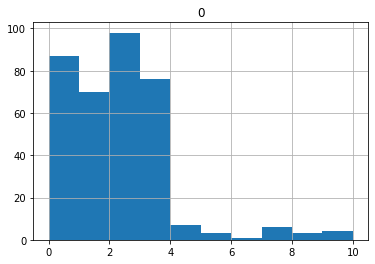

In [85]:
pd.DataFrame(arr).hist()

Nicer labeling of the above plot is possible with using more of Matplotlib... (left as an exercise).

## Find all *jam_factor*s within some range

In [86]:
flatten([flatten([item.topology_segment.topology_segment_id for seg in item.flow.segment if 2 <= seg.jam_factor <= 10])
    for item in data1.items[:100]
])

array([1.04602559e+08, 1.68649121e+08, 2.03437107e+08, 2.13112757e+08,
       8.06910560e+07, 8.94585510e+07, 1.70500394e+08, 1.82148262e+08,
       1.06036584e+08, 1.06036587e+08, 1.06036586e+08, 8.18485990e+07,
       9.94553010e+07, 8.09763690e+07, 1.02251692e+08, 1.03087812e+08,
       1.04602559e+08, 1.68649121e+08, 2.03437107e+08, 2.13112757e+08,
       8.06910560e+07, 8.94585510e+07, 1.70500394e+08, 1.82148262e+08,
       1.06036584e+08, 1.06036587e+08, 1.06036586e+08, 8.18485990e+07,
       9.94553010e+07, 8.09763690e+07, 1.02251692e+08, 1.03087812e+08,
       8.01653898e+08, 8.01660606e+08, 6.33515974e+08, 7.38004910e+08,
       1.79652205e+08, 1.57625492e+08, 1.68775553e+08, 1.70297899e+08,
       1.69323649e+08, 1.70287712e+08, 2.02844195e+08, 4.84446183e+08,
       1.79652205e+08, 1.57625492e+08, 1.68775553e+08, 1.70297899e+08,
       1.69323649e+08, 1.70287712e+08, 2.02844195e+08, 4.84446183e+08,
       1.70147082e+08, 1.38631351e+08, 8.09288050e+07, 9.14403890e+07,
      

## Explore more

In [87]:
data1.items[0].topology_segment.topology_segment_id

[168499001, 171340420]

In [88]:
schema2.schema_to_dict()

ConfigTree([('segment',
             ConfigTree([('_repeated', True),
                         ('_type', 'MESSAGE'),
                         ('_nested',
                          'com.here.platform.data.processing.oma.schema.v2.Segment'),
                         ('identifier',
                          ConfigTree([('_repeated', False),
                                      ('_type', 'STRING'),
                                      ('_nested', None)])),
                         ('start_node_partition_name',
                          ConfigTree([('_repeated', False),
                                      ('_type', 'STRING'),
                                      ('_nested', None)])),
                         ('start_node_identifier',
                          ConfigTree([('_repeated', False),
                                      ('_type', 'STRING'),
                                      ('_nested', None)])),
                         ('end_node_partition_name',
                        

In [89]:
len(data2.segment)

15013

In [90]:
data2.segment[0]

identifier: "here:cm:segment:76333025"
start_node_partition_name: "23602975"
start_node_identifier: "here:cm:node:64050874"
end_node_partition_name: "23602975"
end_node_identifier: "here:cm:node:64050875"
geometry: "{\"type\":\"LineString\",\"coordinates\":[[4.9119,52.2996,0.0],[4.91162,52.29983,0.0]],\"properties\":{\"z-level\":[0,0]}}"
length: 31.93502
partition_name: "23602975"

In [91]:
[seg for seg in data2.segment if seg.identifier=="here:cm:segment:94855590"]

[]

In [92]:
dict2 = {int(seg.identifier.split(':')[-1]): seg.geometry for seg in data2.segment}

In [93]:
dict2

{76333025: '{"type":"LineString","coordinates":[[4.9119,52.2996,0.0],[4.91162,52.29983,0.0]],"properties":{"z-level":[0,0]}}',
 76333083: '{"type":"LineString","coordinates":[[4.87769,52.3065,0.0],[4.87773,52.30756,0.0]],"properties":{"z-level":[0,0]}}',
 76333167: '{"type":"LineString","coordinates":[[4.85755,52.34523,0.0],[4.85753,52.34545,0.0]],"properties":{"z-level":[0,0]}}',
 76364953: '{"type":"LineString","coordinates":[[4.8827,52.36225,0.0],[4.8827,52.36234,0.0],[4.88296,52.36246,0.0]],"properties":{"z-level":[0,0,0]}}',
 76364954: '{"type":"LineString","coordinates":[[4.88347,52.36282,0.0],[4.88343,52.36287,0.0]],"properties":{"z-level":[0,0]}}',
 76420636: '{"type":"LineString","coordinates":[[4.88879,52.38235,0.0],[4.88901,52.38253,0.0]],"properties":{"z-level":[0,0]}}',
 76425874: '{"type":"LineString","coordinates":[[4.85748,52.30636,0.0],[4.85748,52.30667,0.0]],"properties":{"z-level":[0,0]}}',
 76425903: '{"type":"LineString","coordinates":[[4.83482,52.38015,0.0],[4.834

In [94]:
id_set = set()

In [95]:
len(id_set)

0

In [96]:
for i in range(len(data1.items)):
    ids = data1.items[i].topology_segment.topology_segment_id
    id_set = id_set.union(set(ids))
    for id in ids:
        if not id in dict2:
            print(f"missing {id}")

missing 202757628
missing 484364176
missing 78696105
missing 78696107
missing 150332846
missing 143749147
missing 794270296
missing 801656205
missing 182371289
missing 90034895
missing 204344918
missing 173355217
missing 202011945
missing 203056952
missing 90735048
missing 90056840
missing 99598530
missing 741905376
missing 741905362
missing 99694995
missing 660213963
missing 660213816
missing 105741299
missing 738827391
missing 738827267
missing 77771471
missing 77771472
missing 738744779
missing 86383041
missing 92488230
missing 203209279
missing 92488246
missing 92488248
missing 161051861
missing 77750683
missing 137145693
missing 92617010
missing 189625734
missing 189625653
missing 78606736
missing 168038984
missing 157623162
missing 152432842
missing 104552246
missing 102582626
missing 82262104
missing 157623162
missing 82761970
missing 605392874
missing 81319677
missing 104768967
missing 88576838
missing 160831815
missing 102241392
missing 160168543
missing 168787654
missing 1704

## Render

This is a helper function to show a map using the *[Sidecar](https://github.com/jupyter-widgets/jupyterlab-sidecar)* package when installed (works only in Jupyter Lab), or as usual in a classic notebook output cell, otherwise. 

In [97]:
def show_map(map=None, title='Dummy'):
    "Display a map in a sidecar if possible or return it as-is."
    if HAVE_SIDECAR:
        sc = Sidecar(title=title)
        with sc:
            display(map)
    else:
        return map

### Show all segments from OMA catalog

In [98]:
hls = nagini.resource('hls')
m = hls.map(center=[52.51, 13.4], zoom=12)

line_coords_list = [list(json.loads(w)['coordinates']) for w in dict2.values()]
line_coords_dict = {
    "type": "MultiLineString",
    "coordinates": line_coords_list}
lines_geojson = GeoJSON(data=line_coords_dict, style=dict(color='red'))

m.add_layer(lines_geojson)

show_map(map=m, title='OMA Segments')

LeafletMap(basemap={'url': 'https://1.base.maps.api.here.com/maptile/2.1/maptile/newest/normal.day/{z}/{x}/{y}…

### Show segments grouped by jam classes

In [99]:
hls = nagini.resource('hls')
m = hls.map(center=[52.51, 13.4], zoom=12, 
            config=dict(scheme='normal.night', 
                        maptype='traffic', 
                        tiletype='traffictile'))
m.add_control(LayersControl())

color_ranges = [
    {'min': 8, 'max': 10, 'color': 'red'},
    {'min': 6, 'max': 8, 'color': 'orange'},
    {'min': 4, 'max': 6, 'color': 'yellow'},
    {'min': 0, 'max': 4, 'color': 'lime'},
]

for grp in color_ranges:
    segs = flatten([flatten([item.topology_segment.topology_segment_id 
                             for seg in item.flow.segment 
                                 if grp['min'] < seg.jam_factor <= grp['max']])
        for item in data1.items])
    line_coords_list = [list(json.loads(dict2[int(seg)])['coordinates'])
                        for seg in segs if int(seg) in dict2]
    line_coords_dict = {
        "type": "MultiLineString",
        "coordinates": line_coords_list}
    name = f"Jam {grp['min']}-{grp['max']}"
    lines_geojson = GeoJSON(data=line_coords_dict, 
                            style=dict(color=grp['color']),
                            name=name)
    m.add_layer(lines_geojson)
    
show_map(map=m, title='OLP/HLS')

LeafletMap(basemap={'url': 'https://2.traffic.maps.api.here.com/maptile/2.1/traffictile/newest/normal.night/{z…